In [1]:
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"
%pip install pyscf
%pip install ffsim
%pip install qiskit_addon_sqd

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-phq8qwj9/qc-grader_7a08b66ac4eb46869a76e5c75ab74fcf
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-phq8qwj9/qc-grader_7a08b66ac4eb46869a76e5c75ab74fcf
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1d7a6915623b0cfeac4c114391c279e9d98eb7f9
  Preparing metadata (setup.py) ... done
  Attempting uninstall: webcolors
    Found existing installation: webcolors 1.13
    Not uninstalling webcolors at /opt/conda/lib/python3.11/site-packages, outside environment /opt/.qbraid/environments/qgss_000000/pyenv
    Can't uninstall 'webcolors'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

In [1]:
import qiskit
import qc_grader
print(f"Qiskit version: {qiskit.__version__}")
print(f"Grader version: {qc_grader.__version__}")

Qiskit version: 2.1.1
Grader version: 0.22.12


In [2]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'ejUCoSpcBEbkmqm6H4QSdbK6jL1Cs19gYfHRjji7eHaZ',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/d9f30ca59fa549a4b1e8e36b44d1aff9:c023f92e-1cd9-4c71-830b-1ace2cb98a4e::',
  'verify': True,
  'private_endpoint': False}}

In [3]:
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial

# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

# Import grader
from qc_grader.challenges.qgss_2025 import (
    grade_lab3_ex1, 
    grade_lab3_ex2, 
    grade_lab3_ex3,
    grade_lab3_ex4,
    grade_lab3_ex5
)

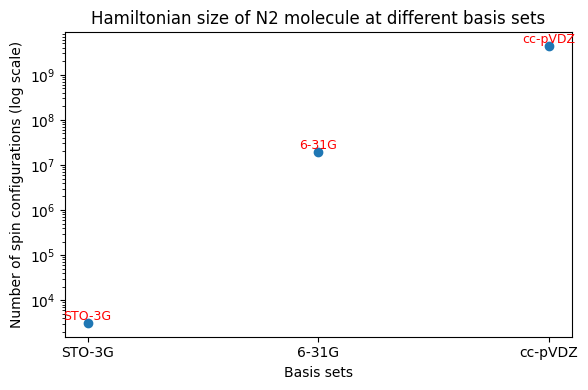

In [4]:
# Number of possible spin configurations
# Example: N2 molecule in STO-3G, 6-31G, and cc-pVDZ basis sets
# 14 electrons, 20 spin orbitals (from 10 spatial orbitals × 2)

# Calculate total electron configurations for each basis set
y1 = comb(8, 5) * comb(8, 5)       # STO-3G
y2 = comb(16, 5) * comb(16, 5)     # 6-31G
y3 = comb(26, 5) * comb(26, 5)     # cc-pVDZ

# Data
y = [y1, y2, y3]
x = list(range(len(y)))
labels = ['STO-3G', '6-31G', 'cc-pVDZ']

# Plot with logarithmic y-scale
plt.figure(figsize=(6, 4))
plt.plot(x, y, 'o')

plt.yscale('log')
plt.xticks(x, labels)
plt.xlabel('Basis sets')
plt.ylabel('Number of spin configurations (log scale)')
plt.title('Hamiltonian size of N2 molecule at different basis sets')

# Add labels above points
for i in range(len(x)):
    plt.text(x[i], y[i], f'{labels[i]}', fontsize=9, ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

In [5]:
import math

# Using core-frozen values directly from table
spin_orbitals = 16
alpha_electrons = 7
beta_electrons = 5

α_config = math.comb(spin_orbitals, alpha_electrons)
β_config = math.comb(spin_orbitals, beta_electrons)
total_config = α_config * β_config

print(f"Total physical configurations for O2 in the given basis: {α_config} x {β_config} = {total_config}")


Total physical configurations for O2 in the given basis: 11440 x 4368 = 49969920


In [6]:

# Submit your answer using following code

grade_lab3_ex1(total_config)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [18]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570774
CASCI E = -109.046671778080  E(CI) = -32.8155692383187  S^2 = 0.0000000


In [19]:

# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929733  E_corr = -0.2045891221988304


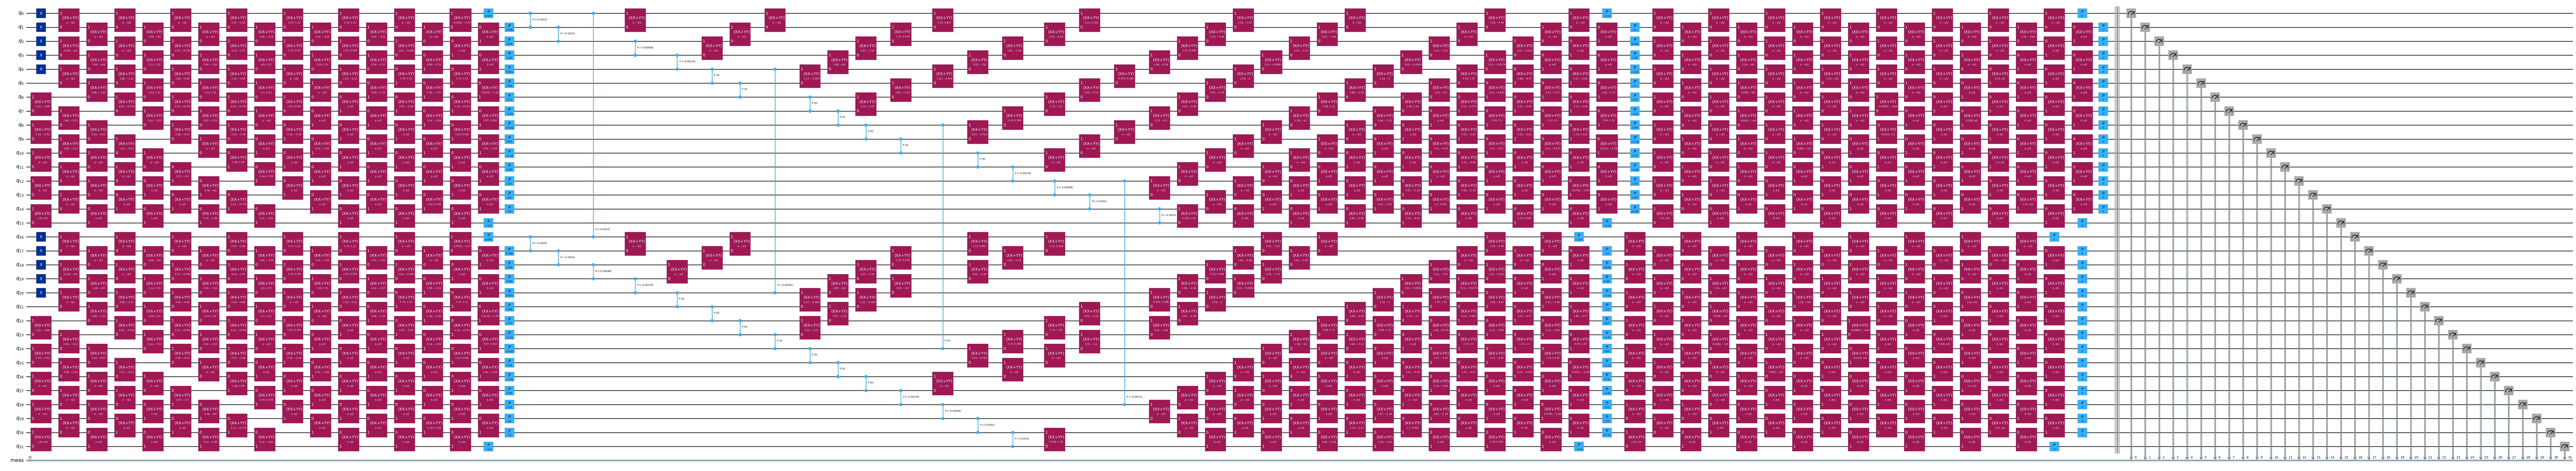

In [20]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

circuit.decompose().decompose().draw("mpl", fold =-1)

In [21]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")

In [22]:

spin_a_layout = [0, 14, 18, 19, 20, 33, 39, 40, 41, 53, 60, 61, 62, 72, 81, 82]
spin_b_layout = [2, 3, 4, 15, 22, 23, 24, 34, 43, 44, 45, 54, 64, 65, 66, 73]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/ pre-init passes): OrderedDict([('rz', 2476), ('sx', 2140), ('ecr', 730), ('x', 79), ('measure', 32), ('barrier', 1)])


In [23]:
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# sampler = Sampler(mode=backend)
# job = sampler.run([isa_circuit], shots=10_000)
# primitive_result = job.result()
# pub_result = primitive_result[0]
# bit_array = pub_result.data.meas

bit_array = np.load('utils/N2_device_bitarray.npy', allow_pickle=True).item()

In [24]:
%%time
# SQD options
energy_tol = 1e-3  
occupancies_tol = 1e-3 
max_iterations = 5

# Eigenstate solver options
num_batches = 5
samples_per_batch = 50
symmetrize_spin = True 
carryover_threshold = 1e-4 
max_cycle = 200
rng = np.random.default_rng(24)


# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)


# List to capture intermediate results
result_history = [] 

def callback(results: list[SCIResult]): 
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -106.27329013141701
		Subspace dimension: 10000
	Subsample 1
		Energy: -105.43810831755866
		Subspace dimension: 9801
	Subsample 2
		Energy: -106.63769425969389
		Subspace dimension: 10000
	Subsample 3
		Energy: -106.61258013830127
		Subspace dimension: 9801
	Subsample 4
		Energy: -106.63164450395635
		Subspace dimension: 9801
Iteration 2
	Subsample 0
		Energy: -107.9108490741182
		Subspace dimension: 9409
	Subsample 1
		Energy: -108.84006034736294
		Subspace dimension: 9604
	Subsample 2
		Energy: -108.84150457670019
		Subspace dimension: 10000
	Subsample 3
		Energy: -107.912900848716
		Subspace dimension: 9409
	Subsample 4
		Energy: -108.84031227231544
		Subspace dimension: 9216
Iteration 3
	Subsample 0
		Energy: -108.89577578545783
		Subspace dimension: 12769
	Subsample 1
		Energy: -108.87738057039104
		Subspace dimension: 12769
	Subsample 2
		Energy: -108.88243139571694
		Subspace dimension: 12321
	Subsample 3
		Energy: -108.86232234859592
		Subspa

In [25]:

def plot_energy_and_occupancy(result_history, exact_energy):

    # Data for energies plot
    x1 = range(len(result_history))
    min_e = [
        min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
        for result in result_history
    ]
    e_diff = [abs(e - exact_energy) for e in min_e]
    yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]
    
    # Chemical accuracy (+/- 1 milli-Hartree)
    chem_accuracy = 0.001
    
    # Data for avg spatial orbital occupancy
    y2 = np.sum(result.orbital_occupancies, axis=0)
    x2 = range(len(y2))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot energies
    axs[0].plot(x1, e_diff, label="energy error", marker="o")
    axs[0].set_xticks(x1)
    axs[0].set_xticklabels(x1)
    axs[0].set_yticks(yt1)
    axs[0].set_yticklabels(yt1)
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-4)
    axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
    axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
    axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
    axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
    axs[0].legend()
    
    # Plot orbital occupancy
    axs[1].bar(x2, y2, width=0.8)
    axs[1].set_xticks(x2)
    axs[1].set_xticklabels(x2)
    axs[1].set_title("Avg Occupancy per Spatial Orbital")
    axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
    axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})
    
    print(f"Exact energy: {exact_energy:.5f} Ha")
    print(f"SQD energy: {min_e[-1]:.5f} Ha")
    print(f"Absolute error: {e_diff[-1]:.5f} Ha")
    plt.tight_layout()
    plt.show()

Exact energy: -109.04667 Ha
SQD energy: -108.96882 Ha
Absolute error: 0.07785 Ha


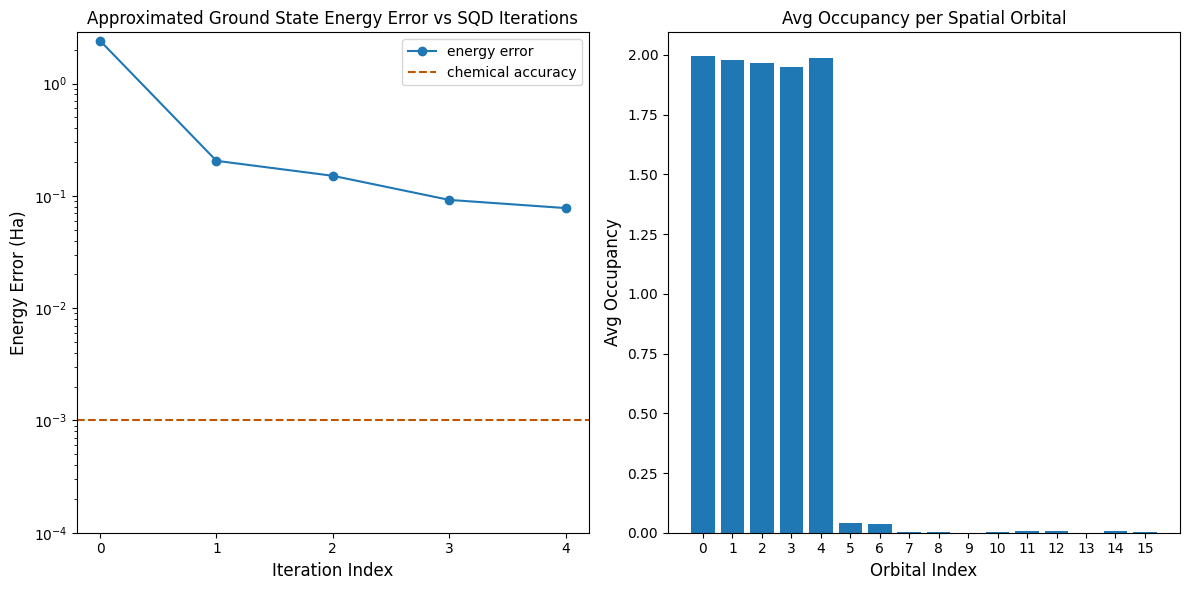

In [26]:
plot_energy_and_occupancy(result_history, exact_energy)

In [27]:

x = [1, 0, 0, 0, 1, 0, 1, 1,
     1, 0, 1, 1, 1, 1, 0, 0]

n = [0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997,
     0.007, 0.029, 0.029, 0.995,
     0.976, 0.976, 0.993, 0.997]

x = np.array(x)
n = np.array(n)

# Split into beta and alpha spin components
x_beta = x[:8]
x_alpha = x[8:]
n_beta = n[:8]
n_alpha = n[8:]

# Calculate flipping probabilities
y_beta = np.abs(x_beta - n_beta)
y_alpha = np.abs(x_alpha - n_alpha)

# Set y_beta[i] = 0 if x_beta[i] is already 1
for i in range(len(y_beta)):
    if x_beta[i] == 1:
        y_beta[i] = 0

# Noise-aware weighting
h = 5 / 8
delta = 0.01
w = np.zeros(len(y_beta))

for i in range(len(y_beta)):
    y = y_beta[i]
    if y <= h:
        w[i] = delta * (y / h)
    else:
        w[i] = delta + (1 - delta) * ((y - h) / (1 - h))

# Flip the index with max w
max_index = np.argmax(w)
max_w = w[max_index]
print("max_index:", max_index, "max_w:", max_w)

# Flip the bit at max_index in x_beta
x_beta[max_index] = 1 - x_beta[max_index]

# Recombine beta + alpha
x = np.concatenate([x_beta, x_alpha])
corrected_x = x.tolist()
print("corrected_x:", corrected_x)


max_index: 3 max_w: 0.9868
corrected_x: [1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


In [28]:
# Submit your answer using following code

grade_lab3_ex2(corrected_x) # Expected result type: list

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [7]:
warnings.filterwarnings("ignore")

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    # ---- TODO : Task 3 ---
    basis="cc-pvdz",
    # --- End of TODO ---
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

print(num_orbitals)

converged SCF energy = -108.929838385609
26


In [8]:
# ---- TODO : Task 3 ---
n_qubits = 2 * num_orbitals + 6
# --- End of TODO ---

In [9]:
# Submit your answer using following code

grade_lab3_ex3(n_qubits) # Expected result type: integer

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend('ibm_torino') 
backend_target = backend.target

In [11]:
backend = service.backend('ibm_torino') 

In [12]:
import qiskit
print(f'Qiskit: {qiskit.__version__}')

Qiskit: 2.1.1


In [13]:
# for Qiskit version 2.0.x users
# with open("utils/backend_target_v20.pkl", "rb") as f:
# for Qiskit version 2.1.x users
with open("utils/backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)

In [14]:
import pickle
import os
with open("utils/backend_target_v21.pkl", "rb") as f:
    backend_target = pickle.load(f)

BAD_READOUT_ERROR_THRESHOLD = 0.1
BAD_CZGATE_ERROR_THRESHOLD = 0.1
backend_num_qubits = 133

# ---- TODO : Task 4
bad_readout_qubits = [
    q for q in range(backend_num_qubits)
    if (
        ("measure" in backend_target)
        and ((q,) in backend_target["measure"])
        and (backend_target["measure"][(q,)].error is not None)
        and (backend_target["measure"][(q,)].error > BAD_READOUT_ERROR_THRESHOLD)
    )
]

bad_czgate_edges = [
    edge for edge, props in backend_target["cz"].items()
    if (props.error is not None) and (props.error > BAD_CZGATE_ERROR_THRESHOLD)
]
# --- End of TODO


print("Bad readout qubits:", bad_readout_qubits)
print("Bad CZ gates:", bad_czgate_edges)



spin_a_layout = [0,15,19,20,21,34,40,41,42,54,61,62,63,73,82,83,84,93,103,104,105,112,124, 123, 122, 121]
spin_b_layout = [2, 3, 4, 16, 23, 24, 25, 35, 44, 45, 46, 55, 65, 66, 67, 74, 86, 87, 88, 94, 107, 108, 109, 113, 128, 127]

initial_layout = spin_a_layout + spin_b_layout

print(len(spin_a_layout))
print(len(spin_b_layout))
print(len(initial_layout))



Bad readout qubits: [12, 53, 115, 126, 131]
Bad CZ gates: [(100, 101), (101, 100)]
26
26
52


In [15]:
# Submit your answer using following code

grade_lab3_ex4(initial_layout) # Expected result type: lists

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [18]:
from pyscf import gto, scf, cc
from qiskit import QuantumCircuit, QuantumRegister
import ffsim
import matplotlib.pyplot as plt

# Step 1: Build molecule
mol = gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)

# Step 2: Run SCF calculation
mf = scf.RHF(mol).run()

# Step 3: Determine orbital counts
full_orbitals = mol.nao_nr()

# Step 4: Freeze core orbitals (1s on each N, assuming indices 0 and 1)
core_orbitals = [0, 1]
active_space = [i for i in range(full_orbitals) if i not in core_orbitals]
num_orbitals = len(active_space)  # should now be 26
frozen_orbitals = core_orbitals

# Optional: Print orbital energies to verify which are core
print("\nOrbital Energies:")
for i, e in enumerate(mf.mo_energy):
    print(f"Orbital {i}: Energy = {e:.6f} Ha")

print("\nUsing", num_orbitals, "active orbitals and freezing orbitals:", frozen_orbitals)

# Step 5: Run CCSD
ccsd = cc.CCSD(mf, frozen=frozen_orbitals).run()
t1 = ccsd.t1
t2 = ccsd.t2

# Step 6: Build UCJ operator
n_reps = 1
alpha_alpha_indices = [(p, p+1) for p in range(0, num_orbitals-1)] + [(p, p+2) for p in range(0, num_orbitals-2)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

# Step 7: Set electron numbers
num_elec_a, num_elec_b = mol.nelec  # total electrons split by spin
nelec = (num_elec_a, num_elec_b)

# Step 8: Create and simulate circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

# Step 9: Draw the circuit
circuit.decompose().decompose().draw("mpl", fold=-1)





converged SCF energy = -108.929838385609

Orbital Energies:
Orbital 0: Energy = -15.655877 Ha
Orbital 1: Energy = -15.649384 Ha
Orbital 2: Energy = -1.544114 Ha
Orbital 3: Energy = -0.741070 Ha
Orbital 4: Energy = -0.653722 Ha
Orbital 5: Energy = -0.653722 Ha
Orbital 6: Energy = -0.633578 Ha
Orbital 7: Energy = 0.230666 Ha
Orbital 8: Energy = 0.230666 Ha
Orbital 9: Energy = 0.616702 Ha
Orbital 10: Energy = 0.785711 Ha
Orbital 11: Energy = 0.840783 Ha
Orbital 12: Energy = 0.840783 Ha
Orbital 13: Energy = 1.006155 Ha
Orbital 14: Energy = 1.077426 Ha
Orbital 15: Energy = 1.077426 Ha
Orbital 16: Energy = 1.298242 Ha
Orbital 17: Energy = 1.727946 Ha
Orbital 18: Energy = 1.727946 Ha
Orbital 19: Energy = 1.767432 Ha
Orbital 20: Energy = 1.993994 Ha
Orbital 21: Energy = 1.993994 Ha
Orbital 22: Energy = 2.370757 Ha
Orbital 23: Energy = 2.370757 Ha
Orbital 24: Energy = 2.953392 Ha
Orbital 25: Energy = 3.108650 Ha
Orbital 26: Energy = 3.108650 Ha
Orbital 27: Energy = 3.597284 Ha

Using 26 active 

In [19]:
# Submit your answer using following code

grade_lab3_ex5(alpha_alpha_indices)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
